<a href="https://colab.research.google.com/github/kevinlu2/COMP5046/blob/main/Labs/COMP5046_Lab02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 02

## Word2Vec

In [1]:
import pprint
import re

# For parsing our XML data
from lxml import etree 

# For data processing
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize

# For implementing the word2vec family of algorithms
from gensim.models import Word2Vec

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Download data from Google Drive
For today's lab we will download and use the TED script data from Google Drive.

#### Google Drive Access Setup
By running the following code, it will generate a link and a field for entering the verification code.

Click the link, which will direct to the Google Sign In page. Sign in with your own Google account by following the instructions on the page.

Then copy the generated verification code from the page into the verification code field and press Enter 

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#### Downloading TED Scripts from Google Drive 
Click on left side "Files" tab and see the file is downloaded successfully.

In [3]:
id = '1B47OiEiG2Lo1jUY6hy_zMmHBxfKQuJ8-'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('ted_en-20160408.xml')  

### Data Preprocessing

In [4]:
targetXML=open('ted_en-20160408.xml', 'r', encoding='UTF8')

# Getting contents of <content> tag from the xml file
target_text = etree.parse(targetXML)
parse_text = '\n'.join(target_text.xpath('//content/text()'))

# Removing "Sound-effect labels" using regular expression (regex) (i.e. (Audio), (Laughter))
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# Tokenising the sentence to process it by using NLTK library
sent_text=sent_tokenize(content_text)

# Removing punctuation and changing all characters to lower case
normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)

# Tokenising each sentence to process individual word
sentences=[]
sentences=[word_tokenize(sentence) for sentence in normalized_text]

# Prints only 10 (tokenised) sentences
print(sentences[:10])

[['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new'], ['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation'], ['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing'], ['consider', 'facit'], ['i', 'm', 'actually', 'old', 'enough', 'to', 'remember', 'them'], ['facit', 'was', 'a', 'fantastic', 'company'], ['they', 'were', 'born', 'deep', 'in', 'the', 'swedish', 'forest', 'and', 'they', 'made', 'the', 'best', 'mechanical', 'calculators', 'in', 'the', 'world'], ['everybody', 'used', 'them'], ['and', 'what', 'did', 'facit', 'do', 'when', 'the', 'electronic', 'calculator', 'came', 'along'], ['they', 'continued', 'doing', 'exactly', 'the', 'same']]


### Word2Vec - Continuous Bag-Of-Words (CBOW)

For more details about gensim.models.word2vec you can refer to [API for Gensim Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html)

In [5]:
# Initialize and train a word2vec model with the following parameters:
# sentence: iterable of iterables, i.e. the list of lists of tokens from our data
# size: dimensionality of the word vectors
# window: window size
# min_count: ignores all words with total frequency lower than the specified count value
# workers: Use specified number of worker threads to train the model (=faster training with multicore machines)
# sg: training algorithm, 0 for CBOW, 1 for skip-gram
wv_cbow_model = Word2Vec(sentences=sentences, size=100, window=5, min_count=5, workers=2, sg=0)

In [6]:
# The trained word vectors are stored in a KeyedVectors instance as model.wv
# Get the top 10 similar words to 'man' by calling most_similar() 
# most_similar() computes cosine similarity between a simple mean of the vectors of the given words and the vectors for each word in the model 

similar_words=wv_cbow_model.wv.most_similar("man") # topn=10 by default
pprint.pprint(similar_words)

[('woman', 0.8340693116188049),
 ('guy', 0.8061996698379517),
 ('lady', 0.7682861089706421),
 ('boy', 0.7678177952766418),
 ('girl', 0.7544349431991577),
 ('soldier', 0.7394479513168335),
 ('gentleman', 0.7391047477722168),
 ('kid', 0.6965989470481873),
 ('photographer', 0.6774575710296631),
 ('rabbi', 0.668375551700592)]


### Word2Vec - Skip Gram

In [7]:
# Now we switch to a Skip Gram model by setting parameter sg=1
wv_sg_model = Word2Vec(sentences=sentences, size=100, window=5, min_count=5, workers=2, sg=1)

In [8]:
similar_words=wv_sg_model.wv.most_similar("man")
pprint.pprint(similar_words)

[('guy', 0.7470706701278687),
 ('woman', 0.7428766489028931),
 ('boy', 0.6943693161010742),
 ('soldier', 0.6870145797729492),
 ('michelangelo', 0.6762663125991821),
 ('rabbi', 0.6621532440185547),
 ('adage', 0.6579524874687195),
 ('son', 0.6563680171966553),
 ('gentleman', 0.6548632383346558),
 ('pope', 0.6484037041664124)]


## Word2Vec vs FastText

Word2Vec - Skip Gram cannot find similar words to "electrofishing" as "electrofishing" is not in the vocabulary.

In [ ]:
similar_words=wv_sg_model.wv.most_similar("electrofishing")
pprint.pprint(similar_words)

KeyError: ignored

### FastText - Skip Gram

In [9]:
from gensim.models import FastText

In [10]:
# Now we initialize and train FastText with Skip Gram architecture (sg=1)
ft_sg_model = FastText(sentences, size=100, window=5, min_count=5, workers=2, sg=1)

In [11]:
# As we can see, FastText allows us to obtain word vectors for out-of-vocabulary words
result=ft_sg_model.wv.most_similar("electrofishing")
pprint.pprint(result)

[('electrolux', 0.8123034834861755),
 ('electro', 0.7991408109664917),
 ('electrolyte', 0.7959124445915222),
 ('electric', 0.7732639312744141),
 ('electroshock', 0.772376537322998),
 ('electrochemical', 0.7620791792869568),
 ('electronic', 0.7615846395492554),
 ('electron', 0.7581126689910889),
 ('electrogram', 0.7563213109970093),
 ('airbus', 0.7552685737609863)]


### FastText - Continuous Bag-Of-Words (CBOW)

In [12]:
# Now we initialize and train FastText with CBOW architecture (sg=0)
ft_cbow_model = FastText(sentences, size=100, window=5, min_count=5, workers=2, sg=0)

In [13]:
# Again, FastText allows us to obtain word vectors for out-of-vocabulary words
result=ft_cbow_model.wv.most_similar("electrofishing")
pprint.pprint(result)

[('electric', 0.9160802364349365),
 ('electro', 0.9015165567398071),
 ('electrolux', 0.8953797817230225),
 ('electronic', 0.8814699053764343),
 ('electron', 0.8771697878837585),
 ('electrolyte', 0.8751893043518066),
 ('electrode', 0.8717366456985474),
 ('electrical', 0.8664981126785278),
 ('electroshock', 0.8596742749214172),
 ('electromagnet', 0.8522251844406128)]


## King - Man + Woman = ?

Try both CBOW and Skip Gram model to calculate "King - Man + Woman = ?"

In [14]:
# We can specify the positive/negative word list with the positive/negative parameters
# Top N most similar words can be specified with the topn parameter
result = wv_cbow_model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

[('president', 0.7754454612731934)]


In [15]:
result = wv_sg_model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)


[('luther', 0.6569207906723022)]


In [16]:
result = ft_cbow_model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)


[('kidding', 0.8954141139984131)]


In [17]:
result = ft_sg_model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)


[('jarring', 0.7055376172065735)]


This is not what we expected...Probably not enough data to answer as "Queen"

Let's try with bigger sized data (Google has already trained Word2Vec with Google News data) in the following section


## Using Pretrained word embeddings with Gensim



### 1.Download and load from Google pretrained Word2Vec binary file
[Link to Project](https://code.google.com/archive/p/word2vec/)

In [18]:
# Download the pre-trained vectors trained on part of Google News dataset (about 100 billion words)
# Beware, this file is big (3.39GB) - might be long waiting! 
id2 = '0B7XkCwpI5KDYNlNUTTlSS21pQmM'
downloaded = drive.CreateFile({'id':id2}) 
downloaded.GetContentFile('GoogleNews-vectors-negative300.bin.gz')  

In [19]:
# Uncompress the downloaded file
!gzip -d /content/GoogleNews-vectors-negative300.bin.gz

**Note: you may encounter a session crash with the pretrained word2vec code below due to out-of-memory issues. If it happens, you may start again directly from this section.**

In [ ]:
from gensim.models import KeyedVectors
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load the pretrained vectors with KeyedVectors instance - might be long waiting! 
filename = 'GoogleNews-vectors-negative300.bin'
gn_wv_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [ ]:
# Now we can try to calculate "King - Man + Woman = ?" again
result = gn_wv_model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

[('queen', 0.7118192911148071)]


### 2.Load a pretrained word embedding model using API
The following code illustrates another way of loading pretrained word embeddings with Gensim. Here we try with GloVe embedding trained on twitter data

In [20]:
import gensim.downloader as api

# download the model and return as object ready for use
model = api.load("glove-twitter-25")  
# The similarity() function can calculate the cosine similarity between two given words
print(model.similarity("cat","dog"))
# The distance() function is another way of calculating the similarity between two given words, which returns 1-cosine similarity instead
print(model.distance("cat","dog"))

[================================================--] 97.1% 101.8/104.8MB downloaded
0.95908207
0.040917932987213135


# [Tips] Play with Colab Form Fields 
**The Form** supports multiple types of fields, including **input fields**, **dropdown menus**. 

In Lab1 E1, we already used the input fields. Let's try more now. You can edit this section by double-clicking it. 

Let's get familiar by changing the value in each input field (on the right) and checking the changes in the code (on the left) - vice versa

In [21]:
#@title Example form fields
#@markdown please put description

string = 'test'  #@param {type: "string"}
slider_value = 111  #@param {type: "slider", min: 100, max: 200}
number = 102  #@param {type: "number"}
date = '2020-01-05'  #@param {type: "date"}
pick_me = "monday"  #@param ['monday', 'tuesday', 'wednesday', 'thursday']
select_or_input = "apples" #@param ["apples", "bananas", "oranges"] {allow-input: true}


#print the output
print("string is",string)
print('slider_value',slider_value)

string is examples
slider_value 111


# Exercise
Please complete the following **two questions** E1 and E2 and and submit your **"ipynb" file to Canvas**. (You can download it using "File" > "Download .ipynb").

##E1. What are the advantages of Facebook's FastText over Google's Word2Vec?
Please write down your answer below with a **supportive example**, using your own words. 

In [ ]:
#@Lab01 - E1

Answer = " Type your answer in here " #@param {type:"raw"}

## E2. Let's find synonyms
Let's assume the cosine similarity, or distance, between two word embedding vectors can indicate if the words are semantically similar to each other. In this exercise, you will implement a function called find_synonym(), in which:

1. A list of 6 words are given
2. You need to implement your own algorithm to find the **synonym for each of the words (i.e. words with the highest cosine similarity or smallest distance)** in the list **from the rest of 5 words** based on the cosine similarity calculated. (Using the .similarity() or distance() function from *Load pretrained word embedding model using API* section above may help)
3. Print out the synonyms found

Please use the pretrained 50-dimensional GloVe word embedding trained on wikipedia and gigaword corpus. (You can use the gensim.downloader to load by passing 'glove-wiki-gigaword-50' to the .load() function, refer to the *Load pretrained word embedding model using API* section above)

Before the function, you may need to import any required libraries.






# New Section

In [37]:
# Complete the following function based on the requirements above

# The list of words to find synonyms
words = ["beautiful", "smart", "clever", "stupid", "lovely", "foolish"]
 
# Load GloVe
import gensim.downloader as api
model = api.load("glove-wiki-gigaword-50")

# Find synonym and return the synonym from the given words list for the given word 
def find_synonym(word_list): 
  # intialise variable to hold results
  result = []
  # iterate through the list of words
  for word in word_list:
    # intialise vairable to hold similarity values
    synonym_value = {}
    # target_list = word_list[:]
    # target_list.remove(word)
    # iterate through other words in list
    for target in word_list:
      # skip if word is itself
      if word == target:
        continue
      # store the comapared word and its similarity value
      synonym_value[target] = model.similarity(word,target)
      # max(d, key=d.get)
      # synonym_value.append(model.similarity(word,w))
    # result.append((word, target_list[synonym_value.index(max(synonym_value))]))

    # keep word and its other word in list wiht highest similarity value
    result.append((word, max(synonym_value, key=synonym_value.get)))
  return result
  
 
# Call the function to get the synonyms and print out the synonyms for each word
# funciton call to get list of synonyms from the given list of words
synonyms = find_synonym(words)
# print out synonyms for each word
for synonym in synonyms:
  print(synonym)

('beautiful', 'lovely')
('smart', 'clever')
('clever', 'smart')
('stupid', 'foolish')
('lovely', 'beautiful')
('foolish', 'stupid')


**E2 Sample output**

The following is **the sample output for E2**, each of the given word is saved in tuple with its synonym, e.g. the given word beautiful and its synonym lovely in the first tuple. - Please just check the **output format**.

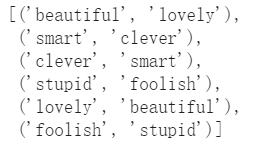

# Extension

## Word Embedding Visual Inspector (WEVI)
If you would like to visualise how Word2Vec is learning, the following link is useful https://ronxin.github.io/wevi/